In [4]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from linearmodels import PanelOLS

In [25]:
#Load data
df = pd.read_excel(sys.path[0]+'/Thesis_Dataset.xlsx')

#Generate summary variables
df['openness'] = df['imports']+df['exports']
df['adj_comp'] = df['avg_comp']/(df['cpi']/100)
df['adj_gdp'] = df['gdp']/(df['cpi']/100)
df['%_change_comp'] = np.log(df['adj_comp']).diff()*100
df['%_change_prod'] = np.log(df['prod']).diff()*100

#Preserve a dataframe with no rolling average
temp = df.set_index(['country','year'])
df_noroll = temp.dropna().drop(['exports','imports','cpi'],axis=1)

#Generate rolling 2-yr averages and drop any rows missing a value
temp = df.set_index(['country','year'])
temp[['roll_comp','roll_unemp','roll_prod']] = df.set_index([
   'year']).groupby('country').rolling(2).mean()[['%_change_comp','unemployment','%_change_prod']]
temp['open_prod'] = temp['openness']*temp['roll_prod']
temp['lag_roll_unemp'] = temp.shift()['roll_unemp']
df = temp.dropna().drop(['exports','imports','cpi'],axis=1)

#Create a decade dummy variable (can tweak parameters for business cycles)
def decades(x):
    if x<1980:
        return 0
    elif x<1990:
        return 1
    elif x<2000:
        return 2
    elif x<2010:
        return 3
    elif x<=2020:
        return 4
    else:
        return 'error'
df_noroll = df_noroll.merge(pd.DataFrame(df_noroll.reset_index()['year'].apply(decades)).rename({
    'year':'decade'},axis=1).join(df_noroll.reset_index()[['country','year']]
    ).set_index(['country','year']), left_index=True, right_on=['country', 'year'])
df = df.merge(pd.DataFrame(df.reset_index()['year'].apply(decades)).rename({
    'year':'decade'},axis=1).join(df.reset_index()[['country','year']]
    ).set_index(['country','year']), left_index=True, right_on=['country', 'year'])

# Variable Explanations

$$Openness_{t} = \frac{imports_{t} + exports_{t}}{GDP_{t}}$$
<br/>
$$AdjustedGDP_{t} = \frac{GDP_{t}}{CPI_{t}}$$
<br/>
$$AdjustedCompensation_{t} = \frac{Compensation_{t}}{CPI_{t}}$$
<br/>
$$RollingCompensation_{t} =\frac{1}{2}\Sigma_{0}^{1}log(\Delta AdjustedCompensation_{t-i})$$
<br/>
$$RollingUnemployment{t} =\frac{1}{2}\Sigma_{0}^{1}Unemployment_{t-i}$$
<br/>
$$RollingProductivity_{t} =\frac{1}{2}\Sigma_{0}^{1}log(\Delta Productivity_{t-i})$$
<br/>
$$LaggedRollingUnemployment{t} =\frac{1}{2}\Sigma_{0}^{1}Unemployment_{t-i-1}$$
<br/>
Abbreviation Key
<ul>
<li>Adjusted Compensation: <em>adj_comp<emp>
<li>Adjusted GDP = <em>adj_gdp<emp>
<li>Rolling Compensation = <em>roll_comp<emp>
<li>Rolling Unemployment = <em>roll_unemp<emp>
<li>Lagged Rolling Unemployment = <em>lag_roll_unemp<emp>
<li>Productivity-Openness Interaction = <em>open_prod<emp>

## Country Code Translator

In [6]:
#Regional Classifications and Country Dictionary
c_dict = {'AUS':'Australia','AUT':'Austria','BEL':'Belgium','CAN':'Canada','CHE':'Switzerland',
         'CHL':'Chile','COL':'Columbia','CRI':'Costa Rica','CZE':'Czech Republic','DEU':'Germany',
         'DNK':'Denmark','ESP':'Spain','EST':'Estonia','FIN':'Finland','FRA':'France',
         'GBR':'Great Britain','GRC':'Greece','HUN':'Hungary','IRL':'Ireland','ISL':'Iceland',
         'ISR':'Isreal','ITA':'Italy','JPN':'Japan','LTU':'Lithuania',
          'LUX':'Luxembourg','LVA':'Latvia','NLD':'Netherlands',
         'NOR':'Norway','NZL':'New Zealand','POL':'Poland','PRT':'Portugal',
          'SVK':'Slovak Republic','SVN':'Slovenia','SWE':'Sweden',
         'USA':'USA'}
eu = ('AUT','BEL','CHE','CZE','DEU','DNK','ESP','EST','FIN','FRA','GBR','GRC','HUN','IRL','ISL',
      'ITA','LTU','LUX','LVA','NLD','NOR','POL','PRT','SVK','SVN','SWE')
na = ('CAN','USA')
sa = ('CHL','COL','CRI')
oc = ('AUS','NZL')
an = ('JPN')
pre91 = ('AUS','CAN', 'DNK', 'FIN', 'FRA', 'ITA', 'NOR','NZL', 'USA')

## Examining Variance in X and T

In [7]:
df_nomulti = df.reset_index()
sev = 0
eig = 0
nin = 0
two = 0
ten = 0
fif = 0
sevc = ()
for i in df_nomulti.groupby('country').min('year')['year']:
        count = 0
        if i <= 1970:
            sev += 1
        if i <= 1980:
            count += 1
            eig += 1
        if i <= 1990:
            count += 1
            nin += 1
        if i<= 2000:
            two += 1
        if i<= 2010:
            ten += 1
        if i<= 2015:
            fif += 1
        else:
            pass
        count +=1
print(f'{sev} start before 1970')
print(f'{eig} start before 1980')
print(f'{nin} start before 1990')
print(f'{two} start before 2000')
print(f'{ten} start before 2010')
print(f'{fif} start before 2015')
df_nomulti.groupby('country').min('year')['year'].plot

0 start before 1970
2 start before 1980
7 start before 1990
26 start before 2000
31 start before 2010
34 start before 2015


Text(50240, 65, 'Costa Rica')

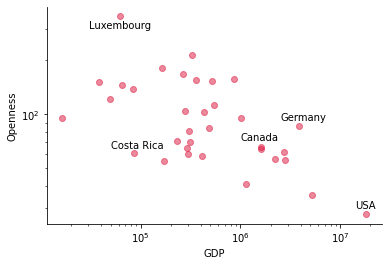

In [8]:
plt.scatter(df_nomulti.loc[df_nomulti['year']==2015]['adj_gdp'],df_nomulti.loc[df_nomulti['year']==2015]['openness'],alpha = .5,
           color='crimson')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('GDP')
plt.ylabel('Openness')
plt.annotate('USA',(14000000,30))
plt.annotate('Luxembourg',(30437,300))
plt.annotate('Canada',(1004850,72))
plt.annotate('Germany',(2509081,93))
plt.annotate('Costa Rica',(50240,65))

# Creating 1991 Summary Graphs

In [9]:
df_91 = df_nomulti[df_nomulti['country'].isin(pre91)].loc[df_nomulti['year']>1990]
pre_91 = list(set(df_91.sort_values('openness')['country']))

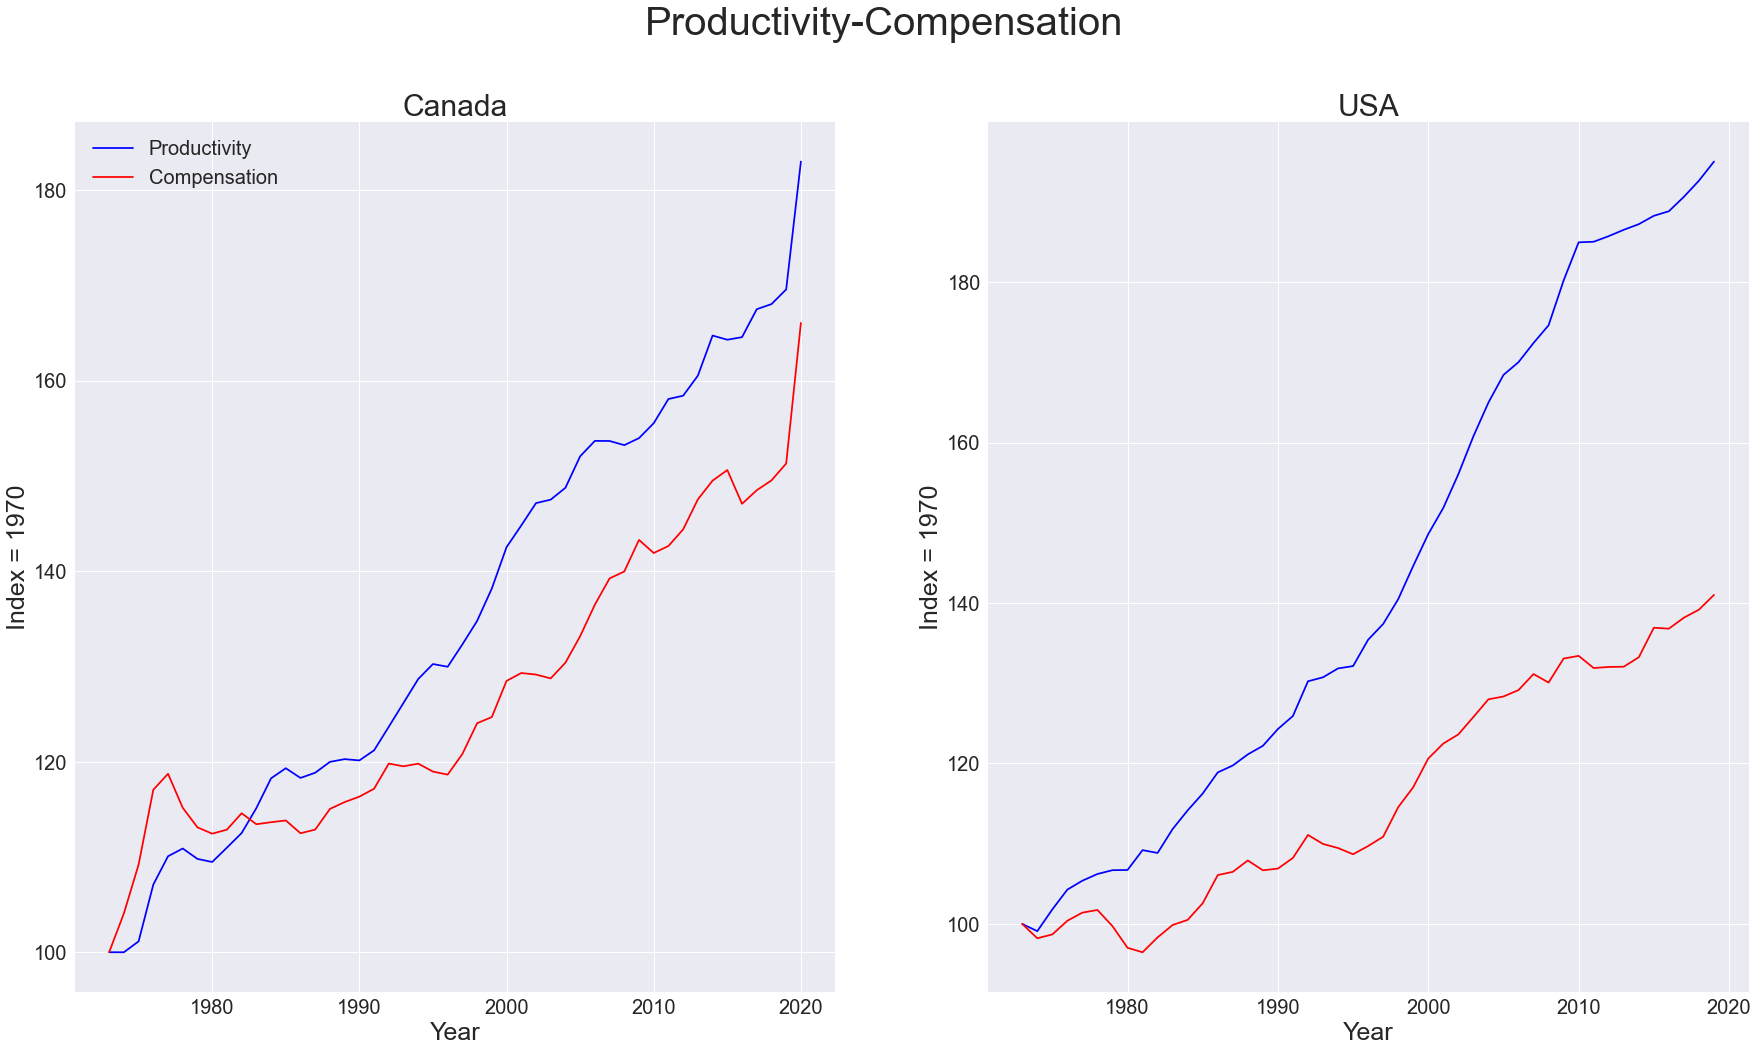

In [10]:
temp = df.reset_index()
temp = temp.loc[temp['year']>1991].set_index(['country','year'])
plt.style.use('seaborn')

prod_CAN = df.loc['CAN'][['prod']]*100/df.loc['CAN'][['prod']].loc[1973]
comp_CAN = df.loc['CAN'][['adj_comp']]*100/df.loc['CAN'][['adj_comp']].loc[1973]
prod_USA = df.loc['USA'][['prod']]*100/df.loc['USA'][['prod']].loc[1973]
comp_USA = df.loc['USA'][['adj_comp']]*100/df.loc['USA'][['adj_comp']].loc[1973]

x = df.loc['CAN'].reset_index()['year']
x_USA = df.loc['USA'].reset_index()['year']

fig, axs = plt.subplots(1,2,figsize = (30,16))
fig.suptitle('Productivity-Compensation',size=40)
for i in [0,1]: 
    axs[i].tick_params(axis = 'both', which = 'major', labelsize = 20)
    axs[i].set_xlabel('Year', size=25)
    axs[i].set_ylabel('Index = 1970', size=25)

axs[0].set_title('Canada',size = 30)
axs[0].plot(x,prod_CAN,color = 'b',label = 'Productivity')
axs[0].plot(x,comp_CAN, color = 'r', label = 'Compensation')

axs[1].set_title('USA',size = 30)
axs[1].plot(x_USA,prod_USA,color = 'b',label = 'Productivity')
axs[1].plot(x_USA,comp_USA, color = 'r', label = 'Compensation')

axs[0].legend(fontsize=20)




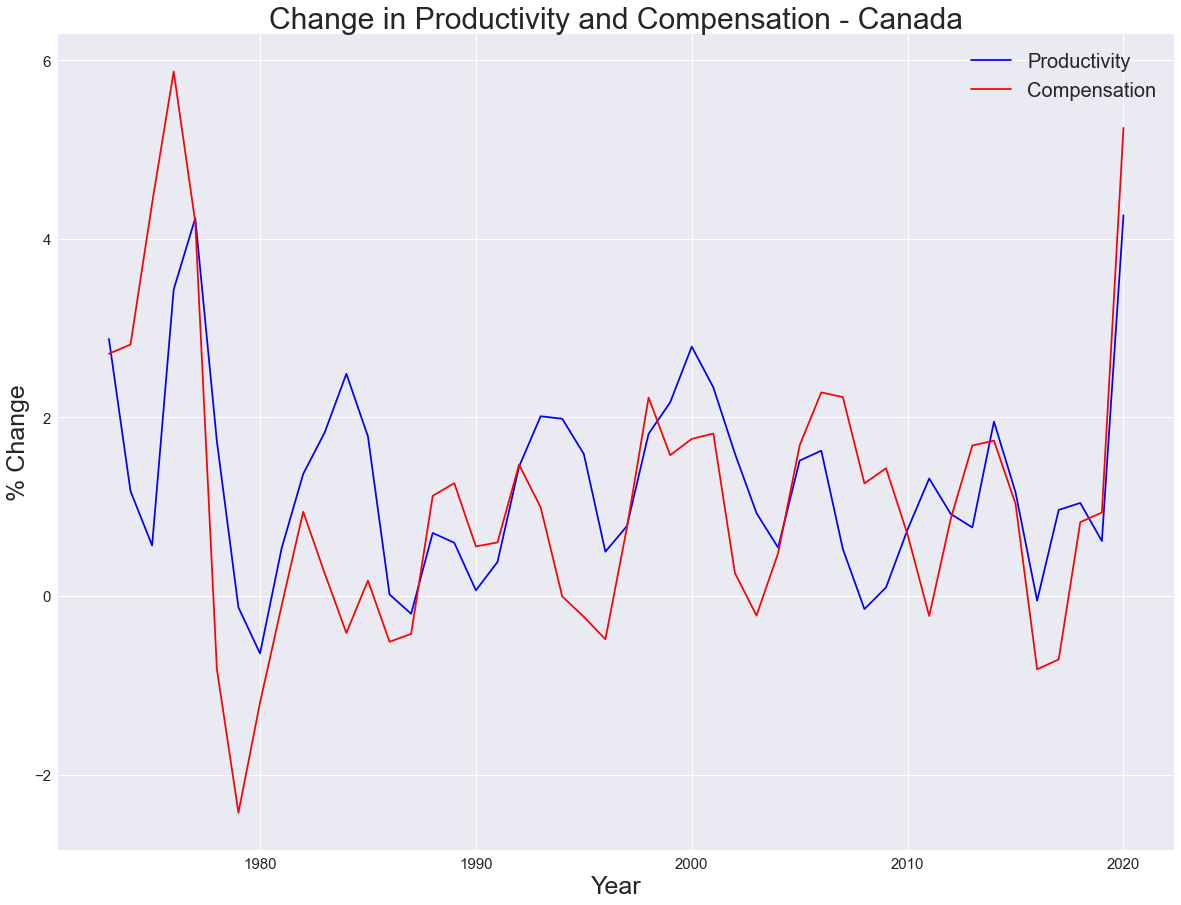

In [11]:
fig, axs = plt.subplots(1,figsize=(20,15))
x = df.loc['CAN'].reset_index()['year']
axs.plot(x,df.loc['CAN']['roll_prod'],label='Productivity',color = 'b')
axs.plot(x,df.loc['CAN']['roll_comp'],label='Compensation',color='r')
axs.tick_params(axis = 'both', which = 'major', labelsize = 15)
axs.set_xlabel('Year', size=25)
axs.set_ylabel('% Change', size=25)
axs.set_title('Change in Productivity and Compensation - Canada',size=30)
axs.legend(fontsize=20)

## Regression 

The full model is as follows:
<br/>
<br/>
$$RollingCompensation_{it} = \alpha + \beta(RollingProductivity_{it}*Openness_{it})+\gamma_1 RollingProductivity_{it} + \gamma_2Openness_{it} +\gamma_3Country_{i} + \gamma_4Decade_{t}$$
<br/>
$$+ \gamma_5RollingUnemployment_{it}+\gamma_6RollingUnemployment_{it-1}+\gamma_7Size_{it}+\epsilon_{it}$$
<br/><br/>List of Regressions Performed:
<ul>
<li>General Regression
<li>European Data Only
<li>Size Controls
<li>No Lag Unemployment Control
<li>No Unemployment Controls
<li>No Decade Fixed Effects

In [12]:
#General Regression
endog = df['roll_comp']
exog = df[['open_prod','roll_prod','openness','roll_unemp','lag_roll_unemp','gdp']].join(pd.get_dummies(df['decade'
        ])).rename({4:'2010s',3:'2000s',2:'1990s',1:'1980s',0:'1970s'},axis=1).drop('1970s',axis=1).assign(cons = [1]*len(endog))
#regression
reg = PanelOLS(endog,exog,entity_effects=True,time_effects=False,other_effects=None)
results = reg.fit(cov_type='clustered', cluster_entity=True)
results

Dep. Variable:,roll_comp,R-squared:,0.4778
Estimator:,PanelOLS,R-squared (Between):,-0.3443
No. Observations:,833,R-squared (Within):,0.4778
Date:,"Tue, Apr 12 2022",R-squared (Overall):,0.1996
Time:,11:29:34,Log-likelihood,-1516.3
Cov. Estimator:,Clustered,,
,,F-statistic:,72.111
Entities:,35,P-value,0.0000
Avg Obs:,23.800,Distribution:,"F(10,788)"
Min Obs:,1.0000,,
Max Obs:,48.000,F-statistic (robust):,14.971


In [37]:
#European Data only
endog = df.loc[list(eu)]['roll_comp']
exog = df.loc[list(eu)][['open_prod','roll_prod','openness','roll_unemp','lag_roll_unemp']].join(pd.get_dummies(df['decade'
      ])).rename({4:'2010s',3:'2000s',2:'1990s',1:'1980s',0:'1970s'},axis=1).drop(['1970s','2010s'],axis = 1).assign(cons = [1]*len(endog))
#regressing
reg = PanelOLS(endog,exog,entity_effects=True,time_effects=False,other_effects=None,check_rank=False,drop_absorbed = True)
results = reg.fit(cov_type='clustered', cluster_entity=True)
results

Dep. Variable:,roll_comp,R-squared:,0.4904
Estimator:,PanelOLS,R-squared (Between):,-0.1562
No. Observations:,624,R-squared (Within):,0.4904
Date:,"Tue, Apr 12 2022",R-squared (Overall):,0.3011
Time:,12:01:28,Log-likelihood,-1181.6
Cov. Estimator:,Clustered,,
,,F-statistic:,70.973
Entities:,34,P-value,0.0000
Avg Obs:,18.353,Distribution:,"F(8,590)"
Min Obs:,0.0000,,
Max Obs:,36.000,F-statistic (robust):,17.755


In [14]:
#Size Controls
endog = df['roll_comp']
exog = df[['open_prod','roll_prod','openness','roll_unemp','lag_roll_unemp','gdp']].join(pd.get_dummies(df['decade'
        ])).rename({4:'2010s',3:'2000s',2:'1990s',1:'1980s',0:'1970s'},axis=1).drop('1970s',axis=1).assign(cons = [1]*len(endog))
#regression
reg = PanelOLS(endog,exog,entity_effects=True,time_effects=False,other_effects=None)
results = reg.fit(cov_type='clustered', cluster_entity=True)
results

Dep. Variable:,roll_comp,R-squared:,0.4778
Estimator:,PanelOLS,R-squared (Between):,-0.3443
No. Observations:,833,R-squared (Within):,0.4778
Date:,"Tue, Apr 12 2022",R-squared (Overall):,0.1996
Time:,11:29:40,Log-likelihood,-1516.3
Cov. Estimator:,Clustered,,
,,F-statistic:,72.111
Entities:,35,P-value,0.0000
Avg Obs:,23.800,Distribution:,"F(10,788)"
Min Obs:,1.0000,,
Max Obs:,48.000,F-statistic (robust):,14.971


In [15]:
#No Lag Unemployment Control
endog = df['roll_comp']
exog = df[['open_prod','roll_prod','openness','roll_unemp']].join(pd.get_dummies(df['decade'
        ])).rename({4:'2010s',3:'2000s',2:'1990s',1:'1980s',0:'1970s'},axis=1).drop('1970s',axis=1).assign(cons = [1]*len(endog))
#regression
reg = PanelOLS(endog,exog,entity_effects=True,time_effects=False,other_effects=None)
results = reg.fit(cov_type='clustered', cluster_entity=True)
results

Dep. Variable:,roll_comp,R-squared:,0.4454
Estimator:,PanelOLS,R-squared (Between):,-0.2169
No. Observations:,833,R-squared (Within):,0.4454
Date:,"Tue, Apr 12 2022",R-squared (Overall):,0.2361
Time:,11:29:42,Log-likelihood,-1541.4
Cov. Estimator:,Clustered,,
,,F-statistic:,79.313
Entities:,35,P-value,0.0000
Avg Obs:,23.800,Distribution:,"F(8,790)"
Min Obs:,1.0000,,
Max Obs:,48.000,F-statistic (robust):,10.795


In [16]:
#No Unemployment Controls
endog = df['roll_comp']
exog = df[['open_prod','roll_prod','openness']].join(pd.get_dummies(df['decade'
        ])).rename({4:'2010s',3:'2000s',2:'1990s',1:'1980s',0:'1970s'},axis=1).drop('1970s',axis=1).assign(cons = [1]*len(endog))
#regression
reg = PanelOLS(endog,exog,entity_effects=True,time_effects=False,other_effects=None)
results = reg.fit(cov_type='clustered', cluster_entity=True)
results

Dep. Variable:,roll_comp,R-squared:,0.2289
Estimator:,PanelOLS,R-squared (Between):,0.4761
No. Observations:,833,R-squared (Within):,0.2289
Date:,"Tue, Apr 12 2022",R-squared (Overall):,0.2998
Time:,11:29:44,Log-likelihood,-1678.6
Cov. Estimator:,Clustered,,
,,F-statistic:,33.551
Entities:,35,P-value,0.0000
Avg Obs:,23.800,Distribution:,"F(7,791)"
Min Obs:,1.0000,,
Max Obs:,48.000,F-statistic (robust):,7.8463


In [17]:
#No Decade Fixed Effects
endog = df['roll_comp']
exog = df[['open_prod','roll_prod','openness','roll_unemp','lag_roll_unemp']].assign(cons = [1]*len(endog))
#regression
reg = PanelOLS(endog,exog,entity_effects=True,time_effects=False,other_effects=None)
results = reg.fit(cov_type='clustered', cluster_entity=True)
results

Dep. Variable:,roll_comp,R-squared:,0.4756
Estimator:,PanelOLS,R-squared (Between):,-0.2976
No. Observations:,833,R-squared (Within):,0.4756
Date:,"Tue, Apr 12 2022",R-squared (Overall):,0.2193
Time:,11:29:47,Log-likelihood,-1518.1
Cov. Estimator:,Clustered,,
,,F-statistic:,143.83
Entities:,35,P-value,0.0000
Avg Obs:,23.800,Distribution:,"F(5,793)"
Min Obs:,1.0000,,
Max Obs:,48.000,F-statistic (robust):,20.733
